In [78]:
%matplotlib inline

In [1]:
from pathlib import Path

def parse_group_name(path):
    """Parse the group name from a path."""
    return path.name.split('_')[0]

data_dir = Path('pictures_all')
group = {}
for path in data_dir.glob('*.jpg'):
    group_name = parse_group_name(path)
    if group_name not in group:
        # Map each group name to an integer group number starting from 0
        group[group_name] = len(group)
group

{'biker': 0,
 'clubber': 1,
 'country': 2,
 'formal': 3,
 'goth': 4,
 'heavy': 5,
 'hiphop': 6,
 'hipster': 7,
 'others': 8,
 'ravers': 9,
 'surfer': 10}

In [2]:
%%time
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils.np_utils import to_categorical
import numpy as np

def parse_group_number(path):
    """Parse the group number from a path."""
    return group[parse_group_name(path)]

images = []
labels = []
for path in data_dir.glob('*.jpg'):
    img = load_img(path)
    images += [img_to_array(img.resize((224, 224)))]
    labels += [parse_group_number(path)]
images = np.stack(images)
labels = to_categorical(np.array(labels), nb_classes=len(group))

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,)
datagen.fit(images)

print(images.shape)
print(labels.shape)
print(labels)

Using TensorFlow backend.


(1158, 224, 224, 3)
(1158, 11)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
CPU times: user 31.8 s, sys: 2.85 s, total: 34.6 s
Wall time: 37 s


In [5]:
val_percent = 0.05
val_index = []
for group_num in range(len(group)):
    group_index = np.where(np.argmax(labels, axis=1) == group_num)[0]
    val_size = int(np.round(len(group_index) * val_percent))
    val_index += list(np.random.choice(group_index, size=val_size, replace=False))
X_val = images[val_index]
Y_val = labels[val_index]
X_train_test = images[list(set(range(len(images))) - set(val_index))]
Y_train_test = labels[list(set(range(len(labels))) - set(val_index))]

test_percent = 0.05
test_index = []
for group_num in range(len(group)):
    group_index = np.where(np.argmax(Y_train_test, axis=1) == group_num)[0]
    test_size = int(np.round(len(group_index) * test_percent))
    test_index += list(np.random.choice(group_index, size=test_size, replace=False))
X_test = X_train_test[test_index]
Y_test = Y_train_test[test_index]
X_train_all = images[list(set(range(len(X_train_test))) - set(test_index))]
Y_train_all = labels[list(set(range(len(Y_train_test))) - set(test_index))]

size = 4
indexes = np.concatenate([np.random.choice(np.where(np.argmax(Y_train_all, axis=1) == i)[0],
                                           size=size)
                          for i in range(len(group))])
X_train = X_train_all[indexes] 
Y_train = Y_train_all[indexes] 


print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(44, 224, 224, 3)
(44, 11)
(57, 224, 224, 3)
(57, 11)
(56, 224, 224, 3)
(56, 11)


In [6]:
import keras
from keras.applications import VGG16
from keras.models import Model
vgg_model = VGG16(weights='imagenet', include_top=True)
vgg_out = vgg_model.layers[-2].output

In [86]:
from keras.callbacks import Callback


class MiniHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epoch = []
        self.batch = []
        self.history = {}
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch.append(epoch)
    
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.epoch.append(self.epoch[-1])
        self.batch.append(batch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
    
    def on_epoch_end(self, epoch, logs=None):
        del self.epoch[-1]

Train on 44 samples, validate on 57 samples
Epoch 1/1
44/44 [==============================] - 99s - loss: 10.2698 - acc: 0.0682 - val_loss: 7.9999 - val_acc: 0.1228
Test score: 6.52875580106
Test accuracy: 0.142857144986


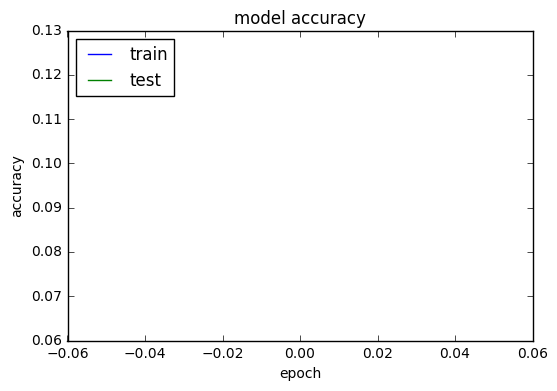

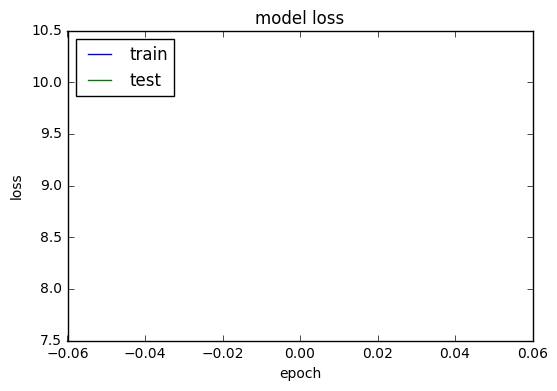

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[5][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[5][0]               
___________________________________________________________________________________________

In [88]:
%%time
import matplotlib.pyplot as plt
from keras.callbacks import BaseLogger
from keras.layers import Dense, Activation
model = keras.models.Sequential(vgg_model.layers[:-2] + [Dense(11, init='he_normal'), Activation('softmax')])
for layer in model.layers[:-2]:
    layer.trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
batch_size = 8
nb_epoch = 1
mini_history = MiniHistory()
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val), callbacks=[mini_history])

# score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.summary()

KeyError: 'val_acc'

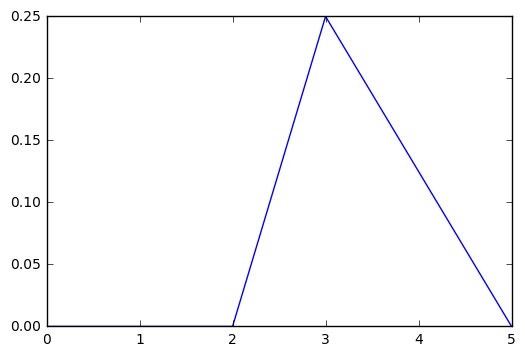

In [89]:
# summarize history for accuracy
plt.plot(mini_history.history['acc'])
plt.plot(mini_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
mini_history.history

{'acc': [0.0, 0.0, 0.0, 0.25, 0.125, 0.0],
 'batch': [0, 1, 2, 3, 4, 5],
 'loss': [12.636806, 10.588995, 9.2242203, 6.7801814, 12.246199, 10.014847],
 'size': [8, 8, 8, 8, 8, 4]}

In [93]:
mini_history.epoch

[0, 0, 0, 0, 0, 0]

In [91]:
history.history

{'acc': [0.068181818181818177],
 'loss': [10.269786401228471],
 'val_acc': [0.12280701754385964],
 'val_loss': [7.999867020991811]}

Train on 44 samples, validate on 57 samples
Epoch 1/10
44/44 [==============================] - 99s - loss: 10.1841 - acc: 0.1136 - val_loss: 8.3303 - val_acc: 0.1404
Epoch 2/10
44/44 [==============================] - 106s - loss: 7.2451 - acc: 0.1818 - val_loss: 7.9456 - val_acc: 0.1579
Epoch 3/10
44/44 [==============================] - 90s - loss: 4.9265 - acc: 0.4091 - val_loss: 7.5904 - val_acc: 0.1754
Epoch 4/10
44/44 [==============================] - 89s - loss: 2.8797 - acc: 0.5682 - val_loss: 7.2004 - val_acc: 0.2456
Epoch 5/10
44/44 [==============================] - 95s - loss: 1.7435 - acc: 0.7727 - val_loss: 7.1856 - val_acc: 0.2281
Epoch 6/10
44/44 [==============================] - 90s - loss: 1.3599 - acc: 0.8864 - val_loss: 7.0308 - val_acc: 0.2632
Epoch 7/10
44/44 [==============================] - 89s - loss: 1.1783 - acc: 0.9318 - val_loss: 7.0103 - val_acc: 0.2632
Epoch 8/10
44/44 [==============================] - 98s - loss: 1.1336 - acc: 0.9318 - val_loss: 6.9

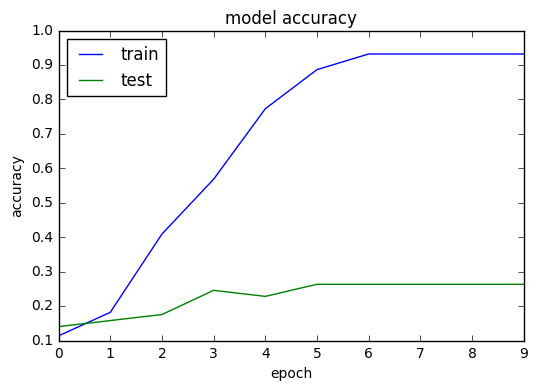

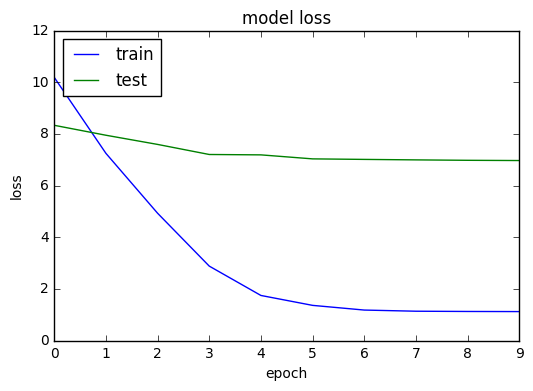

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[2][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[2][0]               
___________________________________________________________________________________________

In [9]:
%%time
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation
model = keras.models.Sequential(vgg_model.layers[:-2] + [Dense(11, init='he_normal'), Activation('softmax')])
for layer in model.layers[:-2]:
    layer.trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
batch_size = 8
nb_epoch = 10
history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.summary()

In [ ]:
history.

In [67]:
layer_name = 'block1_conv1'
# We don't know the difference between node index 0, 1, 2
conv_first_model = Model(input=model.input,
                                 output=model.get_layer(layer_name).get_output_at(0))
conv_first_output = conv_first_model.predict(X_train)

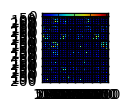

In [80]:
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure(figsize=(8, 8))

grid = AxesGrid(fig, 188,  # similar to subplot(188)
                nrows_ncols=(8, 8),
                axes_pad=0.0,
                share_all=True,
                label_mode="L",
                cbar_location="top",
                cbar_mode="single",
                )

for i in range(64):
    im = grid[i].imshow(conv_first_output[0, :, :, i], interpolation="nearest")
#plt.colorbar(im, cax = grid.cbar_axes[0])
grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(False)

# This affects all axes as share_all = True.
# grid.axes_llc.set_xticks([-2, 0, 2])
# grid.axes_llc.set_yticks([-2, 0, 2])

plt.show()

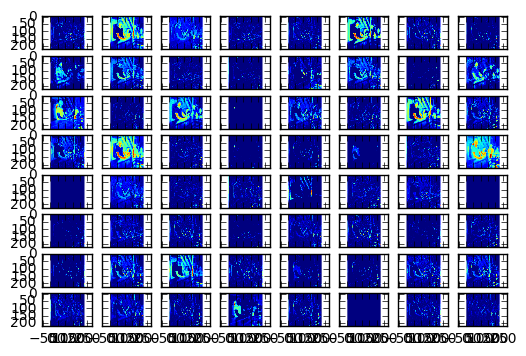

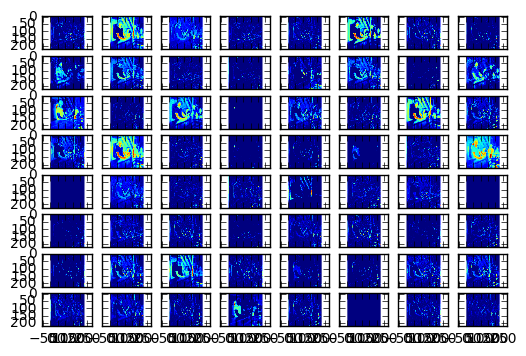

In [74]:
fig, ax = plt.subplots(8, 8, sharex=True, sharey=True)
for row in range(8):
    for col in range(8):
        i_feature = 8 * row + col
        ax[row][col].imshow(conv_first_output[0, :, :, i_feature])
plt.show()

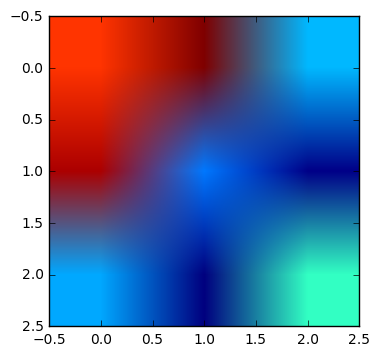

In [10]:
import numpy as np
w = model.layers[2].get_weights()
ww = np.asarray(w)
www = ww[0]
weight = www[:,:,0,0]
type(weight)
plt.imshow(weight)
plt.show()